In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
from pyproj import Proj
from IPython.display import display
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join('../src')))

#import imp
#import land_values
#imp.reload(land_values)
import maps
import land_values
import models

# Extract price-per-acre from scraped data

In [2]:
parsed_df = land_values.parse_landwatch(
    pd.read_pickle('../data/landwatch/large-listings-TX-1-100.pkl'),
    pd.read_pickle('../data/landwatch/google_urls-TX-0-1500.pkl')
)

couldnt parse 141 Acres   Eastland, Eastland County, TX
Contact for Price
couldnt parse 1280 Acres   Mertzon, Irion County, TX
Contact for Price
couldnt parse 2500 Acres   Hunt, Kerr County, TX
Contact for Price
couldnt parse 260 Acres   Seguin, Guadalupe County, TX
Contact for Price
couldnt parse 92 Acres   Camp Verde, Kerr County, TX
Contact for Price
couldnt parse 1795 Acres   Uvalde, Uvalde County, TX
Contact for Price
couldnt parse 121.16 Acres   Stonewall, Gillespie County, TX
Contact for Price
couldnt parse 730 Acres   Kerrville, Gillespie County, TX
Contact for Price
couldnt parse 150 Acres   Carthage, Panola County, TX
Contact for Price
couldnt parse 168.44 Acres   Johnson City, Blanco County, TX
Contact for Price
couldnt parse 154 Acres   Victoria, Victoria County, TX
Contact for Price
couldnt parse 165 Acres   Horseshoe Bay, Llano County, TX
Contact for Price
couldnt parse 910 Acres   Knippa, Uvalde County, TX
Contact for Price
couldnt parse 400 Acres   Beeville, Bee County,

In [3]:
parsed_df

,acres,price,latitude,longitude,ppa
0,968.00,2904000.0,26.621405,-97.985415,3000.000000
1,5.00,699000.0,32.460340,-95.695040,139800.000000
2,19.06,114264.0,30.872315,-95.693680,5994.963274
3,211.99,375000.0,32.067510,-99.698020,1768.951366
4,12119.00,12058405.0,33.407261,-100.120761,995.000000
...,...,...,...,...,...
1495,408.00,3950000.0,32.133500,-94.880000,9681.372549
1496,815.00,1544425.0,27.153800,-99.213300,1895.000000
1497,280.00,1970000.0,31.365990,-96.598375,7035.714286
1498,1055.00,3692500.0,29.294710,-99.965730,3500.000000


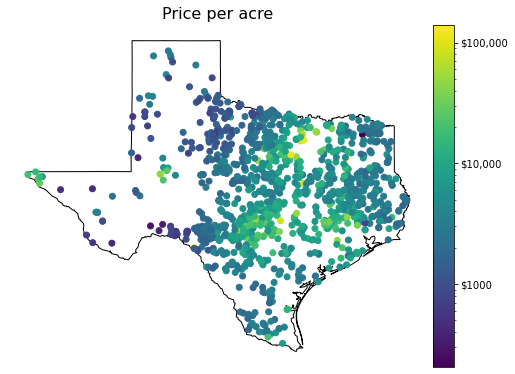

In [9]:
land_values.plot_ppa(parsed_df,'TX')
#plt.savefig('../../figs/land-price-TX-2.png',bbox_inches='tight',transparent=True)
plt.show()

Plot price-per-acre distributions

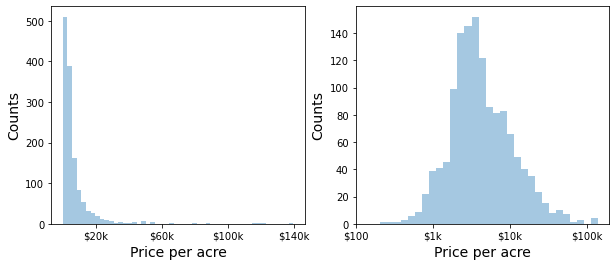

In [61]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.distplot(parsed_df['ppa'],ax=axes[0],kde=False)
sns.distplot(np.log10(parsed_df['ppa']),ax=axes[1],kde=False)

ticks = (np.linspace(2,14,4)*1e4)
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(['${0:1d}k'.format(int(v//1e3)) for v in ticks])

ticks = np.arange(2,6)
axes[1].set_xticks(ticks)
axes[1].set_xticklabels('$100,$1k,$10k,$100k'.split(','))
for ax in axes:
    ax.set_xlabel('Price per acre',fontsize=14)
    ax.set_ylabel('Counts',fontsize=14)
#plt.savefig('../../figs/ppa-dist.png',dpi=300)
plt.show()

# Fit to model

0.3995373622196492


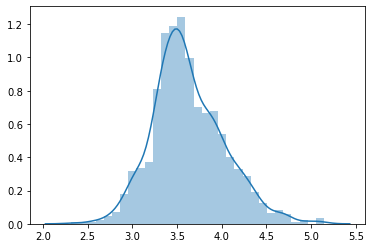

In [64]:
X = parsed_df[['latitude','longitude']]
y = np.log10(parsed_df['ppa']).to_numpy()
sns.distplot(y)
print(np.std(y))

In [65]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel
#model = RandomForestRegressor(n_estimators=400,max_leaf_nodes=16)
#model = GaussianProcessRegressor(kernel = RBF(length_scale=0.05))

kernel = ConstantKernel() + Matern(length_scale = 0.001, nu=5/2) + WhiteKernel(noise_level=0.1)
gp_model = GaussianProcessRegressor(kernel=kernel)
model = gp_model
model = models.fit_regression(model,X,y,score='neg_root_mean_squared_error')

cross validation scores: [-0.2039761  -0.22735033 -0.24558201 -0.23433944 -0.21590768]
mean,std -0.2254311101713963 0.014422993708786079
training data
0.1978668018930697
testing data
0.2396808277979109


In [105]:
lon_range = np.linspace(np.min(parsed_df['longitude']),np.max(parsed_df['longitude']),40)
lat_range = np.linspace(np.min(parsed_df['latitude']),np.max(parsed_df['latitude']),40)
grid = np.meshgrid(lon_range,lat_range,indexing='ij')
grid_pts = np.vstack((grid[1].ravel(),grid[0].ravel())).T
#grid_edges = 
y_pred, y_pred_std = model.predict(grid_pts,return_std=True)

anti_texas = maps.get_state_mask_gdf('TX')

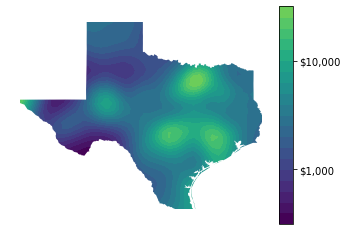

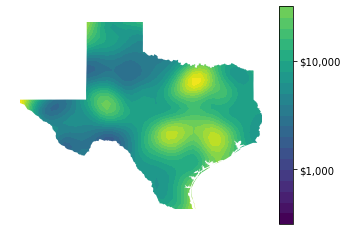

In [104]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
vmax = 5 #np.max(y_pred)
vmin = np.min(y_pred)
im1 = ax.contourf(grid[0],grid[1],y_pred.reshape(grid[0].shape),20,
                 cmap='viridis',vmax=vmax,vmin=vmin);


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1, cax=cax,ticks=[3,4,5])
cbar.ax.set_yticklabels(['$1,000','$10,000','$100,000']) 
#maps.get_state_gpd('TX').plot(ax=ax,color='none',edgecolor='white')
anti_texas.plot(ax=ax,color='white',edgecolor='none')
ax.set_aspect(aspect=1)
ax.axis('off')
plt.show()

fig, ax = plt.subplots()
y_low95 = y_pred + 2*y_pred_std
y_high95 = y_pred + 2*y_pred_std
price_low95 = 10**y_low95
price_high95 = 10**y_high95
confidence_width = price_high95 - price_low95
rel_confidence_width = confidence_width/10**y_pred

test= np.minimum(vmax,y_pred + 2*y_pred_std)
im2 = ax.contourf(grid[0],grid[1],test.reshape(grid[0].shape),20,
                 cmap='viridis',vmax=vmax,vmin=vmin)
anti_texas.plot(ax=ax,color='white',edgecolor='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#cbar = fig.colorbar(im,cax=cax)
cbar = fig.colorbar(im1, cax=cax,ticks=[3,4,5])
#cbar.ax.set_yticklabels(['10%','1%','0.1%']) 
cbar.ax.set_yticklabels(['$1,000','$10,000','$100,000'])
ax.axis('off')
plt.show()
# argsort = np.argsort(y_pred)
# plt.errorbar(y_pred_std,y_pred,yerr=y_pred_std,linestyle='')

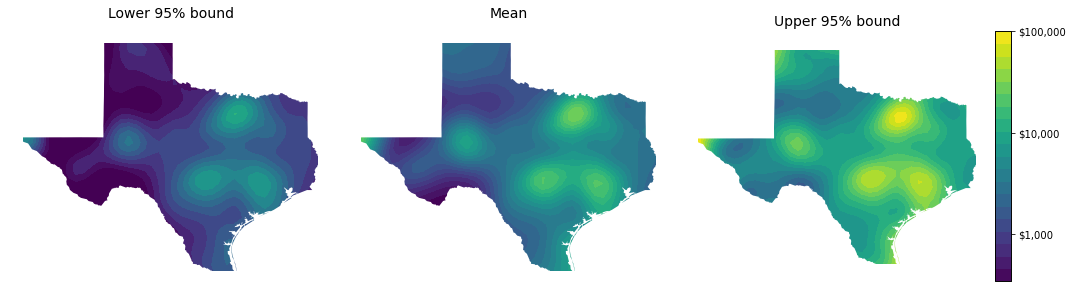

In [167]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(1,3,figsize=(15,5))
vmax = 5 #np.max(y_pred)
vmin = np.min(y_pred)
cmap = 'viridis'

test= np.minimum(vmax,y_pred + 2*y_pred_std)
levels = np.linspace(vmin, vmax, 21)

im3 = axes[0].contourf(grid[0],grid[1],np.minimum(vmax,y_pred - 2*y_pred_std).reshape(grid[0].shape),20,
                 cmap=cmap,vmax=vmax,vmin=vmin);

im1 = axes[1].contourf(grid[0],grid[1],y_pred.reshape(grid[0].shape),20,
                 cmap=cmap,vmax=vmax,vmin=vmin);

im2 = axes[2].contourf(grid[0],grid[1],test.reshape(grid[0].shape),levels,
                 cmap=cmap,vmax=vmax,vmin=vmin)

divider = make_axes_locatable(axes[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2, cax=cax)
cbar = fig.colorbar(im2, cax=cax,ticks=[3,4,5])
cbar.ax.set_yticklabels(['$1,000','$10,000','$100,000']) 

#axes[1].axhline(grid[1][0,15],c='white',linestyle='--')
for ax in axes:
    anti_texas.plot(ax=ax,color='white',edgecolor='none')
    ax.set_aspect(aspect=1)
    ax.axis('off')
for ax, title in zip(axes,['Lower 95% bound','Mean','Upper 95% bound']):
    ax.set_title(title,fontsize=14)
plt.tight_layout()
#plt.savefig('../../figs/tx-interval-heatmap.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


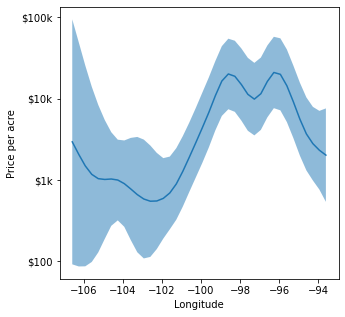

In [163]:
fig, axes = plt.subplots(1,1,figsize=(5,5),sharey=True)
for i,ax in zip((15,),[axes]):
    # plt.errorbar(grid[0][:,i],
    #              y_pred.reshape(grid[0].shape)[:,i],
    #              yerr=2*y_pred_std.reshape(grid[0].shape)[:,i],linestyle='')
    low_95 = (y_pred-2*y_pred_std)
    high_95 = (y_pred+2*y_pred_std)
    ax.plot(grid[0][:,i],y_pred.reshape(grid[0].shape)[:,i])
    ax.fill_between(grid[0][:,i],
                     low_95.reshape(grid[0].shape)[:,i],
                     high_95.reshape(grid[0].shape)[:,i],alpha=0.5)
    ax.set_yticks([2,3,4,5])
    ax.set_yticklabels('$100,$1k,$10k,$100k'.split(','))
    ax.set_ylabel('Price per acre')
    ax.set_xlabel('Longitude')
#plt.savefig('../../figs/gp-slice.png',dpi=300,transparent=True,bbox_inches='tight')  
plt.show()

Save model

In [81]:
# import pickle as pkl
# with fopen('../models/land-price-17.pkl','wb') as f:
#     pkl.dump(model,f)